In [3]:
import sys, pickle
print(sys.executable)
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse

#from temp_tf_load import *
sys.path.append('../../hde')
print(sys.path)
import warnings
warnings.filterwarnings('ignore')
from hde import HDE, analysis

/home/mikejones/scratch-midway2/anaconda3/bin/python3.7
['/scratch/midway2/mikejones/srv/implicit/Analysis', '/home/mikejones/scratch-midway2/anaconda3/bin/python3', '/home/mikejones/scratch-midway2/anaconda3/lib/python37.zip', '/home/mikejones/scratch-midway2/anaconda3/lib/python3.7', '/home/mikejones/scratch-midway2/anaconda3/lib/python3.7/lib-dynload', '', '/home/mikejones/.local/lib/python3.7/site-packages', '/home/mikejones/scratch-midway2/anaconda3/lib/python3.7/site-packages', '/home/mikejones/scratch-midway2/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/mikejones/.ipython', '../../hde']


Using TensorFlow backend.


In [4]:
# stores msm information 
class seqObj:
    
    def __init__(self, seq, temp, ticks, state_list, nstates, nmodes, minflux=3e-6, reduced=True):
        
        self.ticks = ticks
        self.state_list = state_list
        self.nstates = nstates
        self.nmodes = nmodes
        self.minflux = minflux
        
        #set msm directory:
        if reduced:
            self.meta_dir= f'../MSM_construction/MSMs/{seq}_dist_reduced_{temp}K_40-250000-55_micro-200_macro-{nstates}_lag-12_srvlag-12/'
        else:
            self.meta_dir= f'../MSM_construction/MSMs/{seq}_dist_{temp}K_40-250000-190_micro-200_macro-{nstates}_lag-12_srvlag-12/'
        
        self.dist_path = f'../dna_data/{seq}_dist_{temp}K_40-250000-190.npy'
        
        # load pre-run from directory
        self.cluster_hde = pickle.load(open(self.meta_dir + 'hde_cluster.pkl', 'rb'))
        self.cluster_tica = pickle.load(open(self.meta_dir + 'tica_cluster.pkl', 'rb'))

        self.msm_hde = pickle.load(open(self.meta_dir + 'msm_hde.pkl', 'rb'))
        self.msm_tica = pickle.load(open(self.meta_dir + 'msm_tica.pkl', 'rb'))

        self.hde_coords = pickle.load(open(self.meta_dir +'hde_coords.pkl', 'rb'))
        self.tica_coords = pickle.load(open(self.meta_dir +'tica_coords.pkl', 'rb'))

        self.dtraj_tica = self.cluster_tica.dtrajs
        self.dtraj_hde = self.cluster_hde.dtrajs
        
        self.nits, self.lags = 8, 30 #50
        self.its_tica = pyemma.msm.its(self.dtraj_tica, lags=self.lags, nits=self.nits)
        self.its_hde = pyemma.msm.its(self.dtraj_hde, lags=self.lags, nits=self.nits)   #errors='bayes
        
        # calculate transition matrix
        pcca = self.msm_hde.pcca(self.nstates)
        T = pcca.coarse_grained_transition_matrix.copy()
        T[T < 0] *= 0
        self.T = T/T.sum(axis=1)[:, np.newaxis]

# collect all sequence objects into a dict
seq_dict = {}
reduced = True

seq_dict['AT-all'] =  seqObj(seq='AT-all', temp=309, reduced = reduced,
                      ticks = ['A', 'T', 'A', 'T', 'A', 'T', 'A', 'T', 'A', 'T'],
                      state_list=['3S2', '5S2', '3S1', '5S1', 'H', 'D'],
                      nstates= 6, nmodes = 5)

seq_dict['GC-end'] =  seqObj(seq='GC-end', temp=317, reduced = reduced,
                      ticks = ['G', 'A', 'T', 'A', 'T', 'A', 'T', 'A', 'T', 'C'],
                      state_list=['5S2', '3S1', '5S1', 'D', 'H'],
                      nstates= 5, nmodes = 5)

seq_dict['GC-mix'] = seqObj(seq='GC-mix', temp=324, reduced = reduced,
                      ticks = ['A', 'T', 'G', 'A', 'T', 'A', 'T', 'G', 'A', 'T'],
                      state_list=['H', 'D'], 
                      nstates= 2, nmodes = 2)

seq_dict['GC-core'] = seqObj(seq='GC-core', temp=324, reduced = reduced,
                      ticks = ['A', 'T', 'A', 'T', 'G', 'C', 'A', 'T', 'A', 'T'],
                      state_list=['F4', 'H', 'D'], 
                      nstates= 3, nmodes = 3)

In [35]:
#load hde coords from sequence object

## for direct hybridization events
#seq, s1, s2 = 'AT-all', 5, 4
#seq, s1, s2 = 'GC-end', 3, 4
#seq, s1, s2 = 'GC-core', 2, 1
seq, s1, s2 = 'GC-mix', 1, 0

# if true look for hybridization, false look for dissociation
hybrid = False

# load msm and pcca+ discrete trajectories
seqobj = seq_dict[seq]
dtrajs = seqobj.dtraj_hde
meta_assignments = seqobj.msm_hde.metastable_assignments
meta_trajs = meta_assignments[dtrajs]

diag_idxs = [(i+1)*9 for i in range(10)]
print(diag_idxs)
diag_coords = np.load(seqobj.dist_path)[:, :, diag_idxs]

print(np.shape(dtrajs))
print(np.shape(meta_trajs))
print(np.shape(diag_coords))

[9, 18, 27, 36, 45, 54, 63, 72, 81, 90]
(40, 250000)
(40, 250000)
(40, 250000, 10)


In [36]:
# look for stable, slow transitions between states:
# Take 10 transitions x 4 sequences x 200 frames each = 8000 frames

window = 50   # confirm complete transition
edge = 50  # look for sustained at window edge
perc_dif = 5 / window # error in ratio between H and D

dis_cut, hbr_cut = 1, 1
dis_min, hbr_min = 9, 9

# switch initial and final states
if not hybrid:
    tp = s2
    s2 = s1
    s1 = tp

cnt = 0
n_list, i_list = [], []

# look for trnsitions in each trajectory
for n, traj in enumerate(meta_trajs):

    diag_traj = diag_coords[n]
    for i in range(window, len(traj)-window):

        # check for event
        if traj[i] == s1 and traj[i+1] == s2:
            
            # check for sustained event
            s1_dif = np.abs(np.mean(traj[i-window:i-window+edge])-s1)
            s2_dif = np.abs(np.mean(traj[i+window-edge:i+window])-s2)
            
            if s1_dif < perc_dif and s2_dif < perc_dif:
                
                
                # check for complete hybridization
                if hybrid:
                    if np.sum(diag_traj[i-window] > dis_cut)>dis_min and np.sum(diag_traj[i+window] < hbr_cut) >hbr_min:

                        print(n, i)
                        print(np.around(diag_traj[i-window], 2))
                        print(np.around(diag_traj[i+window], 2),  '\n')

                        n_list.append(n)
                        i_list.append(i)
                        cnt+=1

                    # break if only want one event per traj
                    break
                    
                else:
                    if np.sum(diag_traj[i+window] > dis_cut)>dis_min and np.sum(diag_traj[i-window] < hbr_cut) >hbr_min:

                        print(n, i)
                        print(np.around(diag_traj[i-window], 2))
                        print(np.around(diag_traj[i+window], 2),  '\n')

                        n_list.append(n)
                        i_list.append(i)
                        cnt+=1

                    # break if only want one event per traj
                break
                
            
print(cnt)

0 22259
[0.59 0.57 0.55 0.62 0.59 0.59 0.59 0.56 0.61 0.59]
[3.69 3.5  3.5  3.48 3.61 3.91 3.97 3.96 3.72 3.84] 

2 173461
[0.63 0.6  0.55 0.58 0.61 0.6  0.6  0.55 0.6  0.83]
[2.36 2.34 1.89 2.58 3.12 4.07 4.16 4.42 3.68 3.59] 

8 16805
[0.95 0.6  0.58 0.62 0.59 0.61 0.62 0.55 0.58 0.61]
[4.75 4.26 4.73 4.69 4.53 4.64 4.14 3.86 2.89 2.43] 

10 83108
[0.94 0.65 0.56 0.59 0.61 0.58 0.66 0.55 0.6  0.6 ]
[3.31 3.06 3.29 3.36 3.17 3.23 3.11 3.37 2.69 2.79] 

12 20242
[0.61 0.58 0.55 0.59 0.62 0.59 0.6  0.56 0.6  0.62]
[1.17 1.88 2.44 2.8  3.03 3.46 4.69 4.24 3.64 2.68] 

16 106572
[0.99 0.58 0.55 0.59 0.64 0.58 0.6  0.55 0.58 0.89]
[3.18 2.55 2.7  2.99 3.4  3.95 4.52 4.74 4.8  4.61] 

17 199910
[0.97 0.58 0.56 0.6  0.6  0.6  0.64 0.56 0.57 0.6 ]
[4.58 4.99 5.57 5.5  5.24 5.15 5.16 4.84 5.08 4.75] 

19 160982
[0.62 0.59 0.56 0.65 0.61 0.61 0.58 0.55 0.64 0.79]
[5.07 5.05 4.44 4.5  4.76 4.69 4.61 4.44 4.49 4.53] 

21 67790
[0.58 0.59 0.54 0.6  0.6  0.64 0.61 0.54 0.6  0.88]
[2.78 2.04 1.74 1.

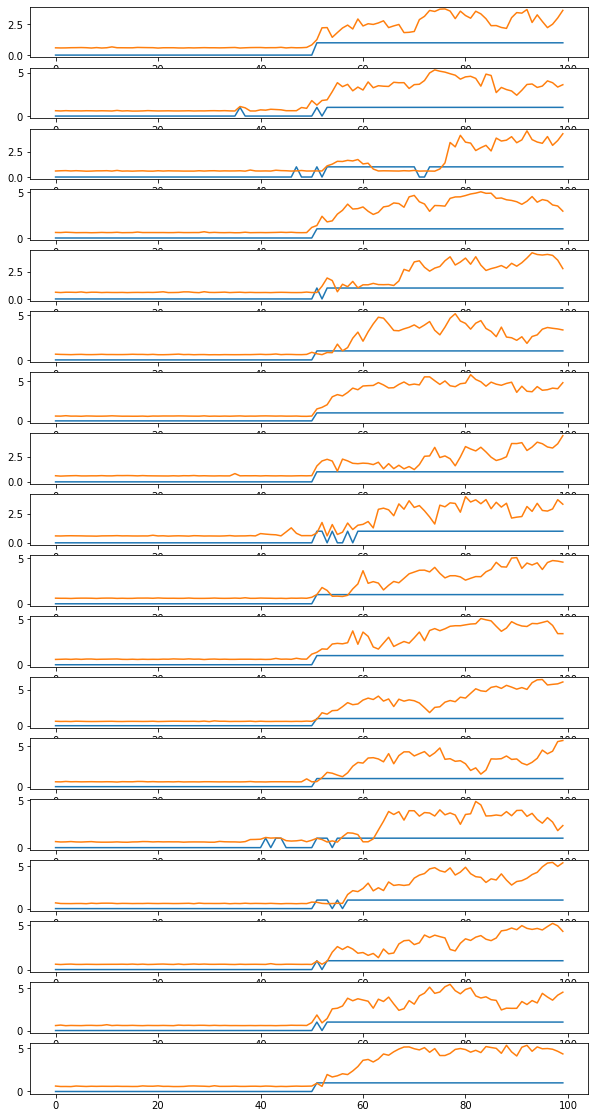

In [37]:
# test plot to evaluate transitions

vis_window = window
fig, axes = plt.subplots(len(n_list), figsize=(10, 20))

for row, (n, i) in enumerate(zip(n_list, i_list)):
    
    ax = axes[row]
    ax.plot(meta_trajs[n][i-window:i+vis_window])
    ax.plot(diag_coords[n][i-window:i+vis_window, 4])

In [38]:
## sort by i_list to find events sooner (less computational time) and save

num_save = 12
sort_idx = np.argsort(i_list)

n_sorted = np.array(n_list)[sort_idx]
i_sorted = np.array(i_list)[sort_idx]

if hybrid: suffix = 'hbr'
else: suffix = 'dis'

np.save(f'{seq}-n_list-{suffix}', n_sorted[:num_save])
np.save(f'{seq}-i_list-{suffix}', i_sorted[:num_save])

In [39]:
print(np.load(f'{seq}-n_list-{suffix}.npy'))

[ 8 12  0 27 37 22 26 38 23 21 31 29]
